# Global synchrony demo

This notebook shows how to build and train a KuraNet instance for learning couplings which promote global synchrony in a disordered Kuramoto model. We will consider a Kuramoto dynamics of the form $$\dot{\theta_i} = \omega_i + \sum_j K_{ij}\sin(\theta_j(t - \tau_j) - \theta_i(t)) + h_i \sin(\theta_i),$$
where $(\omega_i, h_i, \tau_i) \in \mathcal{X}$ are i.i.d. random variables and $(K)_{ij} \in \mathcal{K}$ is an $n \times n$ coupling matrix. We will use a deep neural network to approximate the function $\mathcal{X}^n \times \mathcal{X}^n \to \mathcal{K}$ that makes the oscillators synchronize. The average weighted degree of the graph corresponding to each $K$ is kept at a fixed, small value. The deep neural network is trained to produe couplings which minimize the longterm circular variance $$V = 1 - \lim_{t\to \infty} \frac{1}{n}\left|\sum_j e^{i\theta_j(t)} \right|.$$

The idea, following earlier work by [Brede](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjM667vo8LxAhVhKFkFHUVcCWcQFjAEegQICBAD&url=https%3A%2F%2Farxiv.org%2Fabs%2F0809.4531&usg=AOvVaw23CAmO9BUbJGXzF_m768wE "Brede"), is to force the system to learn couplings which make it synchronize despite limited communication in the network. 

First, we load some modules and set the CUDA device. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from models import KuraNet_full
from train import optimize_connectivity_net
from data import make_data, make_data
from utils import circular_variance
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

## Make data and set parameters

Next we generate and save the random node features $\omega_i, h_i, \tau_i$. You can run three different experiments here, depending on the distributions of these features. We will call the distribution `degenerate` if it's a dirac mass at 0. In general, the more disordered the system, the harder it is to synchronize. Some features are, at least empirically, less conducive to synchrony than others, notably the delays, $\tau_i$. 

The `data.py` script supports multiple types of distributions which you are free to explore. Some distributions lead to interesting phenemona not explored in the companion manuscript (e.g. external fields with mean other than 0). Try them all!

In [2]:
from os.path import expanduser
home = expanduser("~")
data_base_dir = os.path.join(home,'global_synchrony_1')
if not os.path.exists(data_base_dir): os.makedirs(data_base_dir)

num_samples=10000 # Total independent samples to draw and save from each distribution. 
data_names=['omega', 'h', 'tau'] 
dist_names = ['uniform1', 'degenerate', 'degenerate'] # Experiment 1
# dist_names = ['uniform1', 'uniform1', 'degenerate'] # Experiment 2
# dist_names = ['uniform2', 'degenerate', 'negative_binomial'] # Experiment 3

# Uncomment second and third lines if h and tau are not dirac distributions
make_data(data_names[0], dist_names[0], data_base_dir=data_base_dir, num_samples=num_samples)
# make_data(dist_names[1], data_base_dir=data_base_dir, num_samples=num_samples)
# make_data(data_names[2], dist_names[2], data_base_dir=data_base_dir, num_samples=num_samples)

These variables are explained in the extended README. The current settings are for Experiment 1 and similar parameters should work for Experiment 2. Good parameters for the other Experiment 3 seem to be

`Experiment 3`

* `num_epochs = 3`
* `optimizer = SGD`
* `max_grad_norm = 5.0`
* `lr = 5e-2`
* `momentum = .5`


In [3]:
seed=0
model_type='full'
num_classes=0
feature_dim=3
num_units=100
normalize='node'
symmetric=True
avg_deg=1.0
num_epochs=2#2
batch_size=100
burn_in_steps=100
gd_steps=50
alpha=.1
solver_method='euler'
rand_inds=False
adjoint=False
initial_phase='zero'
loss_type='circular_variance'
optimizer='SGD'
momentum=0.0
max_grad_norm=1.0
num_hid_units=128
lr=5e-4 
device='cuda'
measure_cx=True
num_batches = int(num_samples/num_units)

# Load training and testing data.
train_dls  = {}
test_dls   = {}

for dl, regime in zip([train_dls, test_dls], ['train', 'test']):
    for dist_name, data_name in zip(dist_names, data_names):
        if dist_name != 'degenerate':
            dt = np.load(os.path.join(data_base_dir, data_name, dist_name, regime, 'features.npz'))
            ds = TensorDataset(torch.FloatTensor(dt['x']), torch.LongTensor(dt['y'].astype(np.int32)))
        else:
            ds = TensorDataset(torch.zeros(num_samples,1).float(), torch.zeros(num_samples).long())
        dl[data_name] = DataLoader(ds, batch_size=num_units, shuffle=True, drop_last=True)

## Training KuraNet

This cell trains the model on the selected experiment over `num_epochs` passes over the whole node feature data set. On each iteration, a sample of node features is drawn and then passed through the neural network that produces couplings. These couplings then participate in a Kuramoto dynamics whose final steps are evaluated by the specified loss function. 

In [4]:
np.random.seed(seed)
torch.manual_seed(seed)

loss_train, loss_test, kn, cx = optimize_connectivity_net(num_units, feature_dim, train_dls, test_dls, model_type=model_type,
                                                          avg_deg=avg_deg, normalize=normalize, symmetric=symmetric,
                                                          pretrained=False, num_epochs=num_epochs,  batch_size=num_units, 
                                                          burn_in_steps=burn_in_steps, gd_steps=gd_steps,
                                                          alpha=alpha, initial_phase=initial_phase,
                                                          solver_method=solver_method, adjoint=adjoint,
                                                          loss_type=loss_type, optimizer=optimizer,
                                                          lr=lr, momentum=momentum, max_grad_norm=max_grad_norm,
                                                          set_gain=False, gain=1.0,
                                                          num_hid_units=num_hid_units, verbose=1, show_every=10,
                                                          num_eval_batches=10, rand_inds=rand_inds, device=device)


Training. Epoch 0.
Training batch: 0. Time/Batch: 0.9171. Loss: 0.5974764227867126. Gradient norm: 1.0.
Training batch: 10. Time/Batch: 1.052. Loss: 0.5555784702301025. Gradient norm: 1.0.
Training batch: 20. Time/Batch: 1.0179. Loss: 0.4678814709186554. Gradient norm: 1.0.
Training batch: 30. Time/Batch: 0.495. Loss: 0.384150892496109. Gradient norm: 1.0.
Training batch: 40. Time/Batch: 0.8255. Loss: 0.14983227849006653. Gradient norm: 1.0.
Training batch: 50. Time/Batch: 1.1572. Loss: 0.18673065304756165. Gradient norm: 1.0.
Training batch: 60. Time/Batch: 0.4834. Loss: 0.14796389639377594. Gradient norm: 1.0.
Training batch: 70. Time/Batch: 0.5502. Loss: 0.13842619955539703. Gradient norm: 1.0.
Training batch: 80. Time/Batch: 0.7545. Loss: 0.22349879145622253. Gradient norm: 1.0.
Training batch: 90. Time/Batch: 0.9236. Loss: 0.14559219777584076. Gradient norm: 1.0.
Testing. Epoch 0
Testing batch: 0. Time/Batch: 0.6492. Loss: 0.12499683350324631.
Testing batch: 10. Time/Batch: 0.5899

## Visualization

Now, let's view the training loss curve and a sample test graph to see how our model compares to a control. You should be able to reach ~0 testing error for Experiment 1, ~X testing error for Experiment 2 and ~.35 testing error for Experiment 3. 

Optimized loss: 0.0629
Control loss: 0.4480


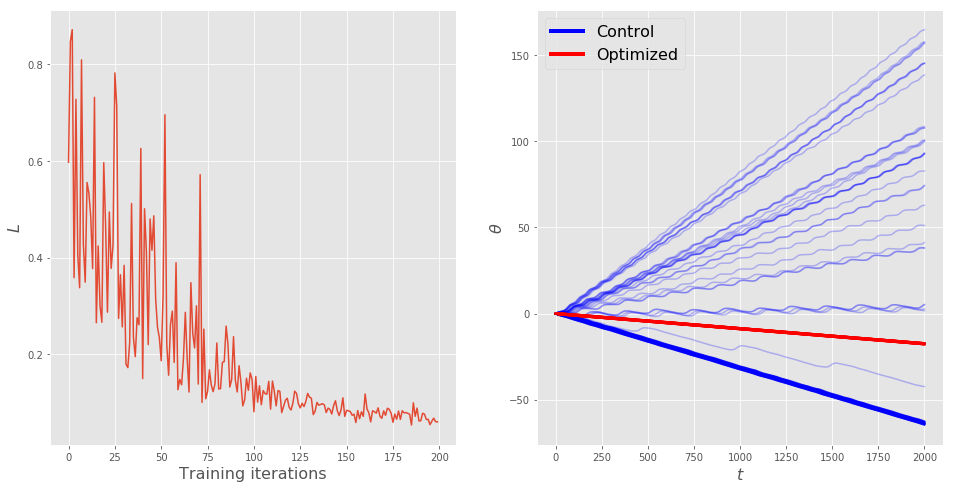

In [5]:
visualization_time=2000
kn_control = KuraNet_full(feature_dim, avg_deg=avg_deg,
             num_hid_units=num_hid_units, initial_phase=initial_phase,
             rand_inds=rand_inds,normalize=normalize, symmetric=symmetric,
             adjoint=adjoint, solver_method=solver_method,set_gain=False, gain=1.0,
             alpha=alpha, gd_steps=1,
             burn_in_steps=visualization_time).to(device)

kn_control.set_batch_size(batch_size)

kn.set_grids(alpha, visualization_time, 1)
# kn_control.set_grids(.01, visualization_time, 1)

data_keys = [key for key in train_dls.keys()]

# Load one testing batch
for j, batch in enumerate(zip(*[test_dls[key] for key in data_keys])):
    X = {key : x.float().to(device) for (key, (x,_)) in zip(data_keys, batch)}
    # Fix max delay for memory problems
    if 'tau' in X.keys():
        X['tau']  = torch.where(X['tau'] > 40.0, 40.0 * torch.ones_like(X['tau']),X['tau'])
    break
    
flow = kn.run(X)
flow_control = kn_control.run(X)
print('Optimized loss: %.04f' % circular_variance(flow[burn_in_steps:]))
print('Control loss: %.04f' % circular_variance(flow_control[burn_in_steps:]))

flow = flow.data.cpu().numpy() 
flow_control=flow_control.data.cpu().numpy()

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], color='b', lw=4),
         Line2D([0], [0], color='r', lw=4)]


fig, axes = plt.subplots(1,2,figsize=(16,8))

axes[0].plot(loss_train)
axes[0].set_xlabel('Training iterations', fontsize=16)
axes[0].set_ylabel(r'$L$', fontsize=16)
axes[1].plot(flow_control, color='b', alpha=.25)
axes[1].plot(flow, color='r', alpha=.25)
axes[1].legend(lines, ['Control', 'Optimized'], fontsize=16)
axes[1].set_xlabel(r'$t$', fontsize=16)
axes[1].set_ylabel(r'$\theta$', fontsize=16)
plt.show()
plt.close()

Not so bad!  The loss should flatten out after about 150 iterations for Experiment 1. On the right, you should see that the untrained control system (blue) desynchronizes quickly while the trained model (red) is comparatively phase-locked. Phase-locking is typically weaker for models with external fields (since the oscillators have to synchronize with each other and the external field) and weaker still with transmission delays. In these cases, rely on the numerical value of the loss to judge performance.

Note that both graphs have the same average node degree, so the increased synchronizability comes from the precise location of weights and not an overall increase in coupling strength. That is, Kuranet has learned.

## Animation

Finally, let's examine the phases of the trained and control model through time. We wil plot them on the unit circle and visualize the mean field as a ray emanating from the origin. Note that when the mean intrinsic frequency is nonzero, the oscillators may spin rather quickly.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
rc('animation', html='html5')

fig, axes = plt.subplots(1,2,figsize=(8,4))
flow_x         = np.cos(flow)
flow_x_control = np.cos(flow_control)
flow_y         = np.sin(flow)
flow_y_control = np.sin(flow_control)

frames = flow.shape[0]

def update(i):
    for ax, sc, ln, fl, fl_cmp in zip(axes, [scatter0,scatter1],[line0, line1], [flow, flow_control], [[flow_x, flow_y], [flow_x_control, flow_y_control]]):
        angle = fl[i,...].mean()
        state = np.concatenate((fl_cmp[0][i,...].reshape(-1,1), fl_cmp[1][i,...].reshape(-1,1)),axis=-1)
        cv = circular_variance(torch.tensor(fl[i,...])).numpy()
        sc.set_offsets(state)
        ln.set_data([0, (1-cv)*np.cos(angle)],[0, (1-cv)*np.sin(angle)])
    return scatter0,scatter1,line0,line1,

scatters = []
lines = []
for ax, cl, fl, fl_cmp in zip(axes, ['r','b'],[flow, flow_control], [[flow_x, flow_y], [flow_x_control, flow_y_control]]):
    ax.set_xlim(( -1.25, 1.25))
    ax.set_ylim((-1.25, 1.25))
    ax.add_patch(plt.Circle((0, 0), 1.0, color='gray', fill=False))
    scatter = ax.scatter(fl_cmp[0][0,...], fl_cmp[1][0,...], color=cl, alpha=.15)
    angle = fl[0,...].mean()
    state = np.concatenate((fl_cmp[0][0,...].reshape(-1,1), fl_cmp[1][0,...].reshape(-1,1)),axis=-1)
    cv = circular_variance(torch.tensor(fl[0,...])).numpy()
    line, = ax.plot([0, (1-cv)*np.cos(angle)],[0, (1-cv)*np.sin(angle)], color = cl, linewidth = 1)
    lines.append(line)
    scatters.append(scatter)

scatter0 = scatters[0]
scatter1 = scatters[1]
line0 = lines[0]
line1 = lines[1]

# You might have to change `interval` for when the omega mean frequency is nonzero, since it will spin quite fast in this case. 
anim = FuncAnimation(fig, update, frames=frames, blit=True, interval=20)
html = HTML(anim.to_html5_video())
display(html)
plt.close() # update
# Save
# anim.save(os.path.join(home, 'kuramoto.mp4'), writer='ffmpeg', fps=45)
